In [21]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [22]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [23]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [24]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [25]:
ticker='TSLA'

In [26]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [27]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [28]:
dates = pd.to_datetime(df['Date'])

In [29]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [30]:
df_for_training = df[cols].astype(float)

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [32]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [33]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [34]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [35]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [36]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [37]:
def build_model(input_shape, output_shape):
    model=Sequential()
    model.add(GRU(64,activation='relu',input_shape=input_shape,return_sequences=False))
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)


Epoch 1/1000
4/4 [==============================] - 1s 59ms/step - loss: 0.2125 - val_loss: 0.4015
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.1499

4/4 [==============================] - 2s 796ms/step - loss: 0.1948 - val_loss: 0.3760
Epoch 3/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.1783 - val_loss: 0.3516
Epoch 4/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.1626 - val_loss: 0.3283
Epoch 5/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.1479 - val_loss: 0.3061
Epoch 6/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.1341 - val_loss: 0.2850
Epoch 7/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.1212 - val_loss: 0.2650
Epoch 8/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.1092 - val_loss: 0.2460
Epoch 9/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0981 - val_loss: 0.2281
Epoch 10/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0879 - val_loss: 0.2113
Epoch 11/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0785 - val_loss: 0.1957
Epoch 12/1000
4/4 [=

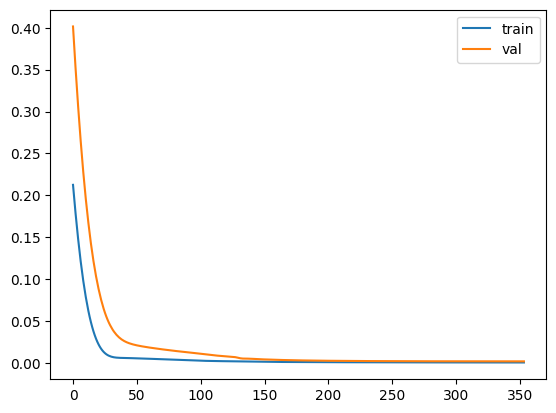

4/4 [==============================] - 0s 3ms/step
mae: 0.8351611035885432


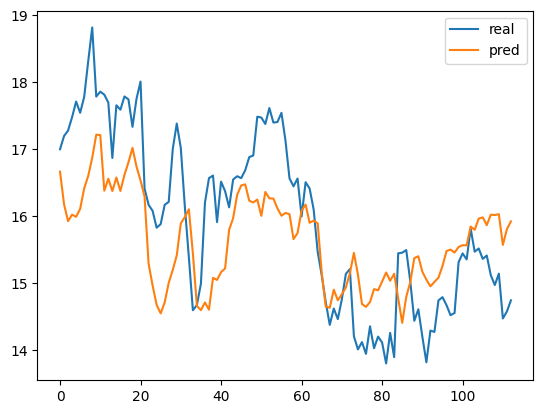

Epoch 1/1000
7/7 [==============================] - 1s 33ms/step - loss: 0.0720 - val_loss: 0.0505
Epoch 2/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0544 - val_loss: 0.0362
Epoch 3/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0397 - val_loss: 0.0247
Epoch 4/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0281 - val_loss: 0.0159
Epoch 5/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0193 - val_loss: 0.0096
Epoch 6/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0131 - val_loss: 0.0053
Epoch 7/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0027
Epoch 8/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 9/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 7.2341e-04
Epoch 10/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 5.4157e-04
E

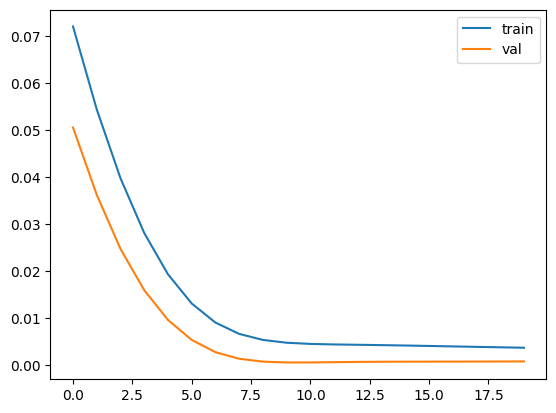

4/4 [==============================] - 0s 3ms/step
mae: 1.4860700662296262


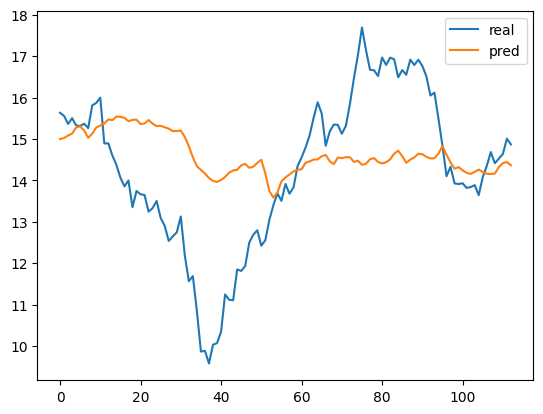

Epoch 1/1000
10/10 [==============================] - 1s 27ms/step - loss: 0.0483 - val_loss: 0.0313
Epoch 2/1000
10/10 [==============================] - 0s 21ms/step - loss: 0.0356 - val_loss: 0.0221
Epoch 3/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0262 - val_loss: 0.0154
Epoch 4/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0194 - val_loss: 0.0107
Epoch 5/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0148 - val_loss: 0.0076
Epoch 6/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0056
Epoch 7/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0100 - val_loss: 0.0045
Epoch 8/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0089 - val_loss: 0.0038
Epoch 9/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 10/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0078 - val_lo

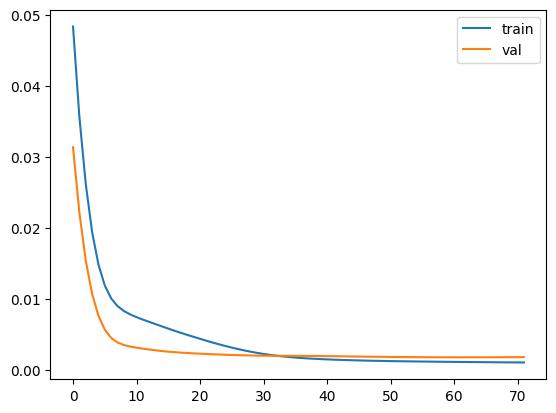

4/4 [==============================] - 0s 4ms/step
mae: 1.0152631272172505


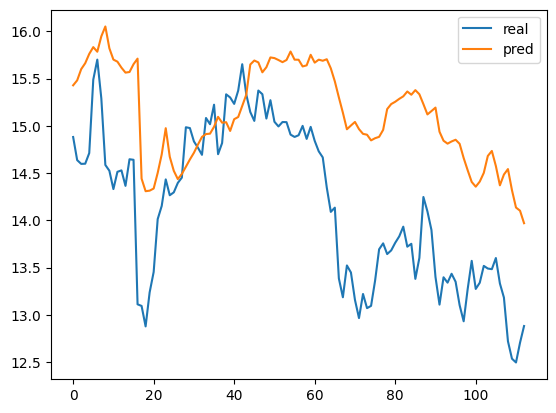

Epoch 1/1000
13/13 [==============================] - 1s 26ms/step - loss: 0.1060 - val_loss: 0.0270
Epoch 2/1000
13/13 [==============================] - 0s 20ms/step - loss: 0.0711 - val_loss: 0.0098
Epoch 3/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0461 - val_loss: 0.0018
Epoch 4/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0299 - val_loss: 3.8496e-04
Epoch 5/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0206 - val_loss: 0.0026
Epoch 6/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0160 - val_loss: 0.0057
Epoch 7/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0139 - val_loss: 0.0083
Epoch 8/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 9/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 10/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0116 - va

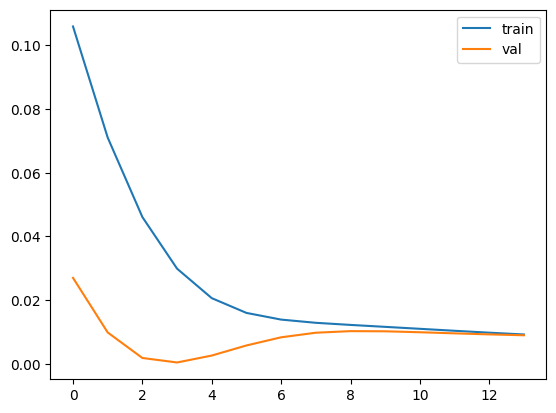

4/4 [==============================] - 0s 3ms/step
mae: 2.604427068156825


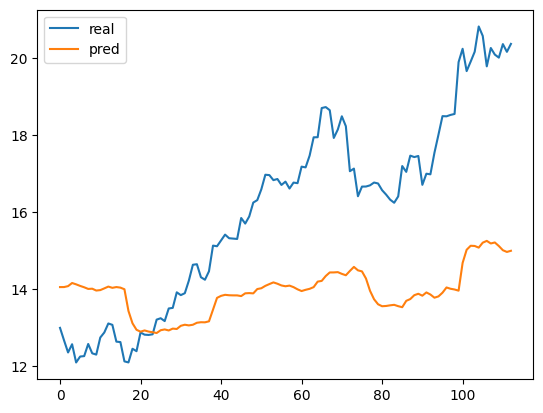

Epoch 1/1000
17/17 [==============================] - 1s 30ms/step - loss: 0.1110 - val_loss: 0.2974
Epoch 2/1000
17/17 [==============================] - 0s 23ms/step - loss: 0.0704 - val_loss: 0.2151
Epoch 3/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.0428 - val_loss: 0.1524
Epoch 4/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.0249 - val_loss: 0.1067
Epoch 5/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.0144 - val_loss: 0.0750
Epoch 6/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.0089 - val_loss: 0.0541
Epoch 7/1000
17/17 [==============================] - 0s 22ms/step - loss: 0.0064 - val_loss: 0.0412
Epoch 8/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.0054 - val_loss: 0.0336
Epoch 9/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.0051 - val_loss: 0.0292
Epoch 10/1000
17/17 [==============================] - 0s 20ms/step - loss: 0.0050 - val_lo

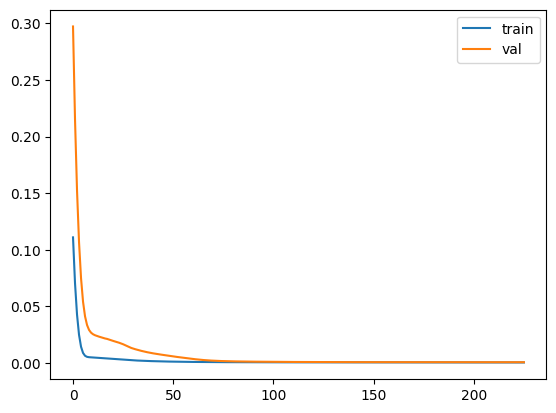

4/4 [==============================] - 0s 2ms/step
mae: 0.7987356166592489


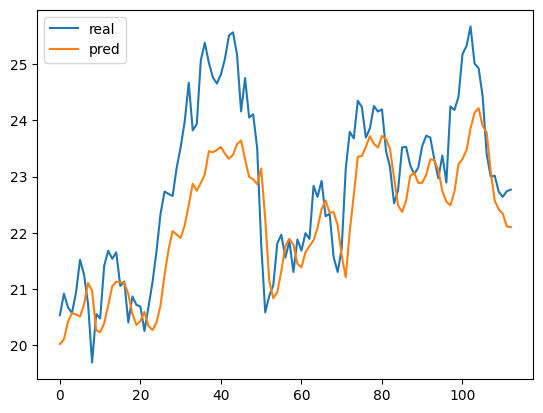

Epoch 1/1000
20/20 [==============================] - 1s 24ms/step - loss: 0.0707 - val_loss: 0.3114
Epoch 2/1000
20/20 [==============================] - 0s 19ms/step - loss: 0.0433 - val_loss: 0.2334
Epoch 3/1000
20/20 [==============================] - 0s 19ms/step - loss: 0.0266 - val_loss: 0.1762
Epoch 4/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.0170 - val_loss: 0.1332
Epoch 5/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 0.1011
Epoch 6/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.0100 - val_loss: 0.0803
Epoch 7/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0679
Epoch 8/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.0090 - val_loss: 0.0602
Epoch 9/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.0086 - val_loss: 0.0549
Epoch 10/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.0083 - val_lo

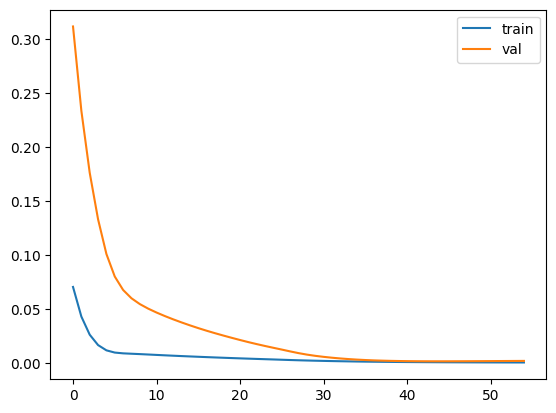

4/4 [==============================] - 0s 3ms/step
mae: 1.3660781058803324


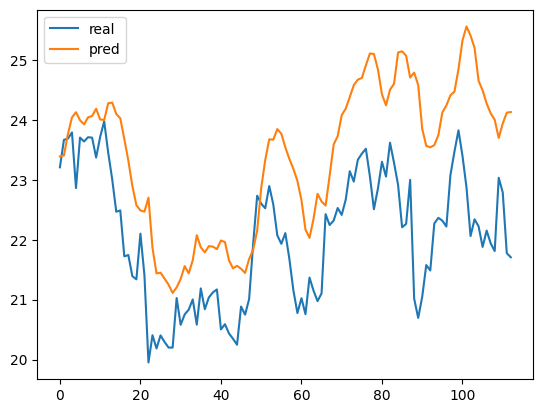

Epoch 1/1000
23/23 [==============================] - 1s 21ms/step - loss: 0.0229 - val_loss: 0.0660
Epoch 2/1000
23/23 [==============================] - 0s 18ms/step - loss: 0.0156 - val_loss: 0.0368
Epoch 3/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0124 - val_loss: 0.0216
Epoch 4/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0106 - val_loss: 0.0135
Epoch 5/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 6/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 7/1000
23/23 [==============================] - 0s 18ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 8/1000
23/23 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 9/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 10/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0039 - val_lo

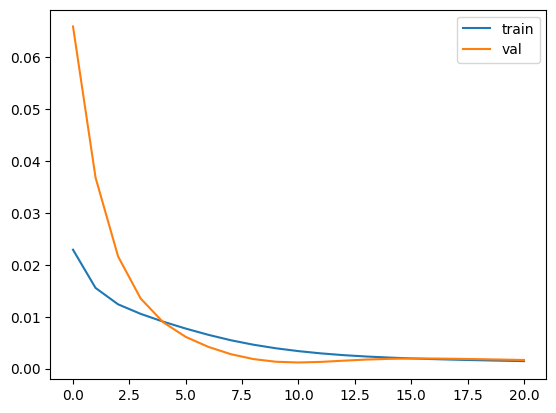

4/4 [==============================] - 0s 3ms/step
mae: 1.3872432650438158


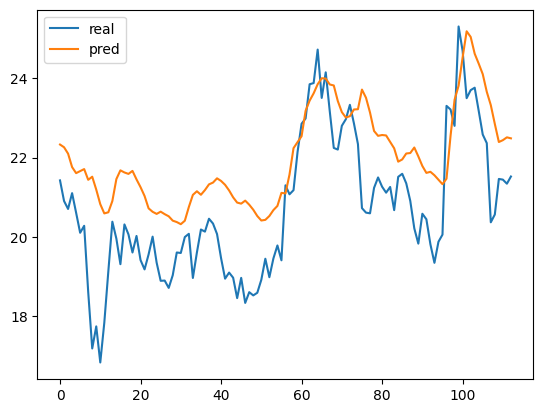

Epoch 1/1000
26/26 [==============================] - 2s 34ms/step - loss: 0.4177 - val_loss: 0.9516
Epoch 2/1000
26/26 [==============================] - 0s 18ms/step - loss: 0.2540 - val_loss: 0.5935
Epoch 3/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.1502 - val_loss: 0.3522
Epoch 4/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0847 - val_loss: 0.1922
Epoch 5/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0469 - val_loss: 0.0961
Epoch 6/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0279 - val_loss: 0.0446
Epoch 7/1000
26/26 [==============================] - 0s 18ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 8/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0165 - val_loss: 0.0102
Epoch 9/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0147 - val_loss: 0.0060
Epoch 10/1000
26/26 [==============================] - 0s 17ms/step - loss: 0.0133 - val_lo

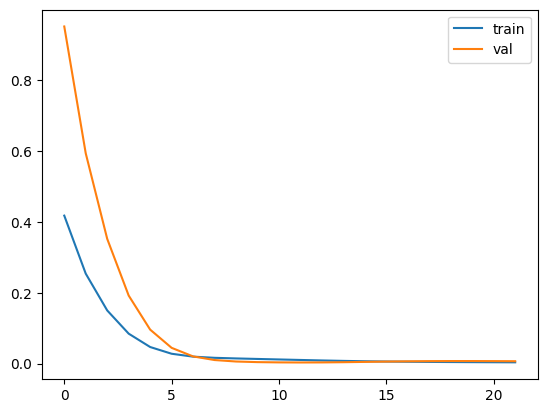

4/4 [==============================] - 0s 5ms/step
mae: 1.762886381235309


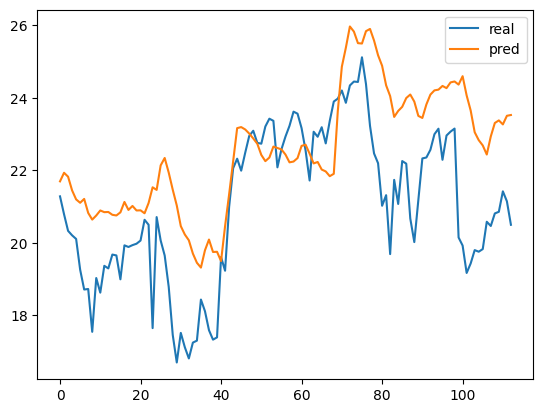

Epoch 1/1000
29/29 [==============================] - 1s 21ms/step - loss: 0.3924 - val_loss: 0.5642
Epoch 2/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.2158 - val_loss: 0.2867
Epoch 3/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.1100 - val_loss: 0.1209
Epoch 4/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0506 - val_loss: 0.0369
Epoch 5/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0234 - val_loss: 0.0104
Epoch 6/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0143 - val_loss: 0.0085
Epoch 7/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 8/1000
29/29 [==============================] - 1s 17ms/step - loss: 0.0110 - val_loss: 0.0139
Epoch 9/1000
29/29 [==============================] - 1s 20ms/step - loss: 0.0100 - val_loss: 0.0149
Epoch 10/1000
29/29 [==============================] - 1s 18ms/step - loss: 0.0091 - val_lo

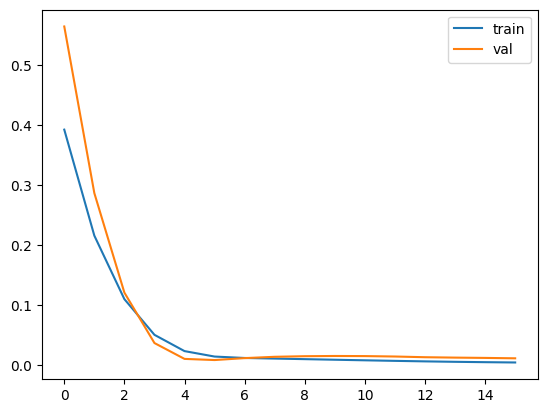

4/4 [==============================] - 0s 3ms/step
mae: 3.4940736594508346


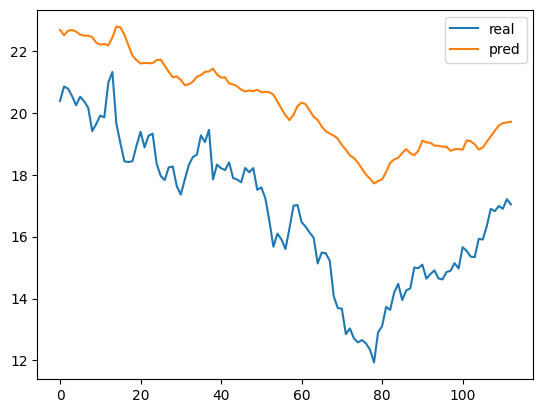

Epoch 1/1000
32/32 [==============================] - 1s 11ms/step - loss: 0.2916 - val_loss: 0.2052
Epoch 2/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.1754 - val_loss: 0.0907
Epoch 3/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.1041 - val_loss: 0.0352
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0622 - val_loss: 0.0178
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0407 - val_loss: 0.0216
Epoch 6/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0308 - val_loss: 0.0332
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0262 - val_loss: 0.0445
Epoch 8/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0236 - val_loss: 0.0524
Epoch 9/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0216 - val_loss: 0.0567
Epoch 10/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.058

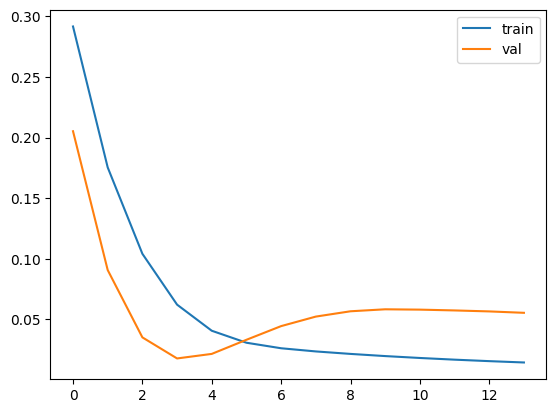

4/4 [==============================] - 0s 2ms/step
mae: 3.262018655554307


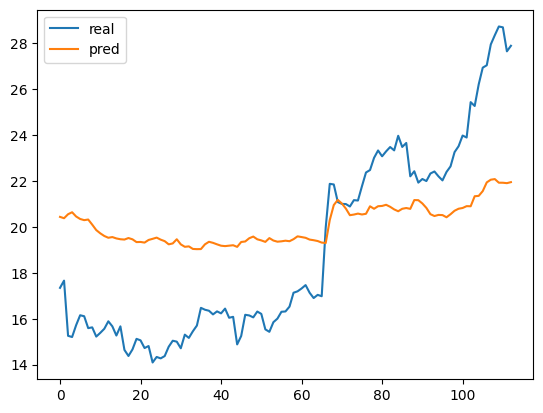

In [38]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()



In [39]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 64)                15936     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16001 (62.50 KB)
Trainable params: 16001 (62.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
average_mae=np.mean(maes)
print('average mae:',average_mae)

average mae: 1.8011957049016094
